In [1]:
import yfinance as yf
import pandas as pd

In [2]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

In [3]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-15 00:00:00-04:00,4365.330078,4439.200195,4362.600098,4425.839844,4176690000,0.0,0.0
2023-06-16 00:00:00-04:00,4440.950195,4448.470215,4407.439941,4409.589844,6848600000,0.0,0.0
2023-06-20 00:00:00-04:00,4396.109863,4400.149902,4367.189941,4388.709961,4055790000,0.0,0.0


<Axes: xlabel='Date'>

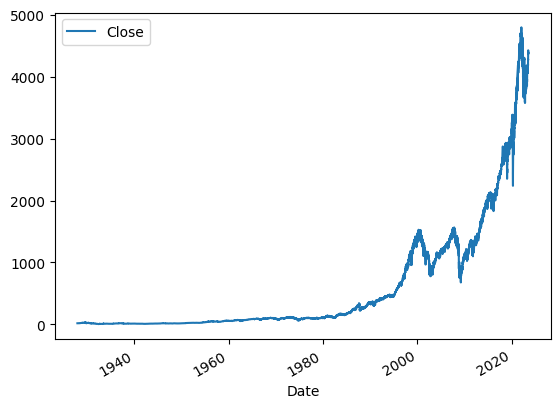

In [4]:
sp500.plot.line(y="Close", use_index=True)
#y axis is closing price and x axis is date

In [5]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [6]:
#shifts the close price up one day
sp500["Tomorrow"] = sp500["Close"].shift(-1)
#creates a new column called target and sets it to 1 if tomorrow is greater than today
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [7]:
#start the date at 1990
sp500 = sp500.loc["1990-01-01":].copy()


In [8]:
#split the data into training and testing
#choose Random Forest Classifier because it is a classification problem
from sklearn.ensemble import RandomForestClassifier
#n_estimators is the number of trees in the forest
#min_samples_split is the minimum number of samples required to split an internal node
#random_state is the seed used by the random number generator
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [9]:
from sklearn.metrics import precision_score
#predicts the target for the test data
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6176470588235294

<Axes: xlabel='Date'>

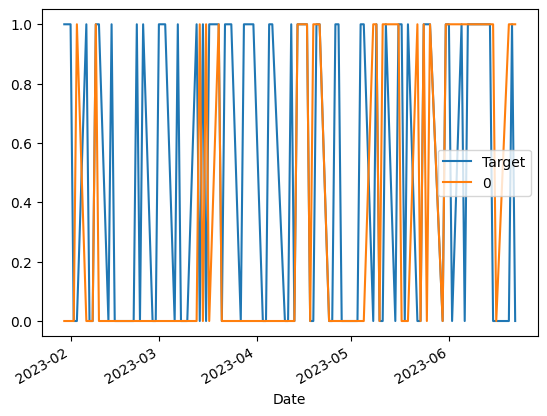

In [10]:
#combined is a dataframe that contains the target and the predictions
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()
#we can see that the predictions are not very accurate and are not very close to the target


In [11]:
#predicts the target for the training data
def predict(train, test, predictors, model):
    #train predictors against target
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [12]:
#backtest the model
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    #for eg we can take first 10years as training data and the next 1 year as testing data and then we take 11 years as training data and the next 1 year as testing data
    for i in range(start, data.shape[0], step):
        #train data is from 0 to i
        train = data.iloc[0:i].copy()
        #test data is from i to i+step
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [13]:
predictions = backtest(sp500, model, predictors)

<Axes: xlabel='Predictions'>

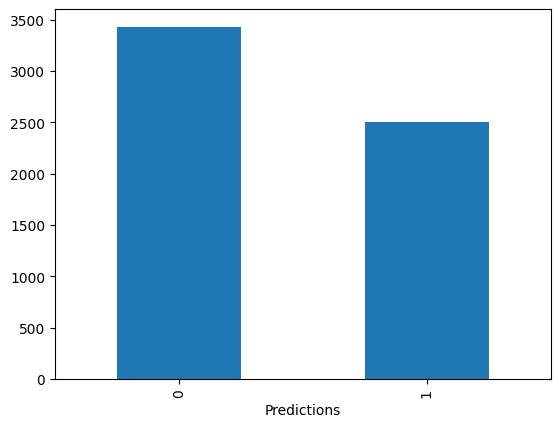

In [14]:
#plot the predictions
predictions["Predictions"].value_counts().plot.bar()

In [15]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5293882447021192

In [16]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [17]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-15 00:00:00-04:00,4365.330078,4439.200195,4362.600098,4425.839844,4176690000,4409.589844,0,1.006052,2.0,1.014857,5.0,1.066704,35.0,1.110229,120.0,1.171738,537.0
2023-06-16 00:00:00-04:00,4440.950195,4448.470215,4407.439941,4409.589844,6848600000,4388.709961,0,0.998161,1.0,1.006023,4.0,1.060773,35.0,1.105338,119.0,1.166977,536.0
2023-06-20 00:00:00-04:00,4396.109863,4400.149902,4367.189941,4388.709961,4055790000,4365.689941,0,0.997627,0.0,0.998990,3.0,1.053891,34.0,1.099416,118.0,1.161007,535.0


In [18]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [19]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.7] = 1
    preds[preds <.7] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [20]:
predictions = backtest(sp500, model, new_predictors)

In [21]:
predictions["Predictions"].value_counts()

Predictions
0.0    4917
1.0      16
Name: count, dtype: int64

In [22]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5625